In [1]:
import csv
import folium
from folium.plugins import MarkerCluster
import numpy as np
import pandas as pd
#import ast
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

coord_data = []
points = []
data = pd.read_csv('prepared_data.csv')#импорт данных

data = data.dropna()
coord_data = list(data['coords'])
for i in range(len(coord_data)):
    tmp = coord_data[i].split(',')
    points.append([float(tmp[0][1:]), float(tmp[1][0:-1])])
data = data.reset_index(drop=True)
data['coords'] = pd.Series(points)
data['id'] = pd.Series(range(len(points)))
print(data)

        id                 coords  weight  height
0        0   [56.21883, 43.86902]  3560.0    53.0
1        1  [56.22218, 43.860675]  3700.0    54.0
2        2  [56.27995, 43.931103]  2920.0    49.0
3        3  [56.22298, 43.976225]  3060.0    49.0
4        4  [56.33455, 43.956579]  3220.0    50.0
...    ...                    ...     ...     ...
5915  5915  [56.23386, 43.968518]  3050.0    52.0
5916  5916  [56.14405, 44.187114]  3880.0    56.0
5917  5917  [56.33735, 44.118797]  3050.0    54.0
5918  5918  [57.46223, 45.588108]  2880.0    50.0
5919  5919  [56.38024, 44.019192]  4390.0    59.0

[5920 rows x 4 columns]


In [2]:
for point in data.iterrows():
    print(point)

(0, id                           0
coords    [56.21883, 43.86902]
weight                  3560.0
height                    53.0
Name: 0, dtype: object)
(1, id                            1
coords    [56.22218, 43.860675]
weight                   3700.0
height                     54.0
Name: 1, dtype: object)
(2, id                            2
coords    [56.27995, 43.931103]
weight                   2920.0
height                     49.0
Name: 2, dtype: object)
(3, id                            3
coords    [56.22298, 43.976225]
weight                   3060.0
height                     49.0
Name: 3, dtype: object)
(4, id                            4
coords    [56.33455, 43.956579]
weight                   3220.0
height                     50.0
Name: 4, dtype: object)
(5, id                            5
coords    [56.27522, 43.923153]
weight                   3340.0
height                     50.0
Name: 5, dtype: object)
(6, id                            6
coords    [56.34198, 43.944982]


In [3]:
city_coord = [56.15, 43.6]
m = folium.Map(location = city_coord)
fg = folium.FeatureGroup(name="Icon collection", show=False).add_to(m)
folium.LayerControl().add_to(m)
marker_cluster = MarkerCluster().add_to(fg)

for index, point in data.iterrows():
    folium.Marker(location = point.coords).add_to(marker_cluster)

m

In [4]:
polygons = {}

with open('geodata.json') as f:#импорт размеченных районов
    templates = json.load(f)
for i in templates['features']:
    #print(i['properties'])
    print(i['geometry'], '\n')
    polygons[i['properties']['id']] = Polygon(i['geometry']['coordinates'][0])
print(polygons)

{'coordinates': [[[43.8895203672771, 56.35384602069175], [43.8895203672771, 56.336353456524904], [43.924349868629264, 56.336353456524904], [43.924349868629264, 56.35384602069175], [43.8895203672771, 56.35384602069175]]], 'type': 'Polygon'} 

{'coordinates': [[[43.98856676174765, 56.32935418467818], [43.98856676174765, 56.31112592055106], [44.03101521652138, 56.31112592055106], [44.03101521652138, 56.32935418467818], [43.98856676174765, 56.32935418467818]]], 'type': 'Polygon'} 

{'coordinates': [[[43.8886496297435, 56.32742312515896], [43.8886496297435, 56.30025725277838], [43.93849935355345, 56.30025725277838], [43.93849935355345, 56.32742312515896], [43.8886496297435, 56.32742312515896]]], 'type': 'Polygon'} 

{'coordinates': [[[43.98901285536999, 56.304620119124195], [43.98901285536999, 56.27765656898083], [44.04249754746044, 56.27765656898083], [44.04249754746044, 56.304620119124195], [43.98901285536999, 56.304620119124195]]], 'type': 'Polygon'} 

{'coordinates': [[[43.8881676725725

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import openpyxl
import datetime

t_height = {}
t_weight = {}
count = 0
for i in polygons:
    for index, point in data.iterrows():
        if polygons[i].contains(Point(point['coords'][1], point['coords'][0])):
            #print(point)
            if t_weight.get(i) == None:
                t_weight[i] = []
                t_height[i] = []
            t_weight[i].append(point['weight'])
            t_height[i].append(point['height'])
for i in t_weight:
    print(len(t_weight[i]), i)    

88 1
92 2
260 3
97 4
688 5
93 6


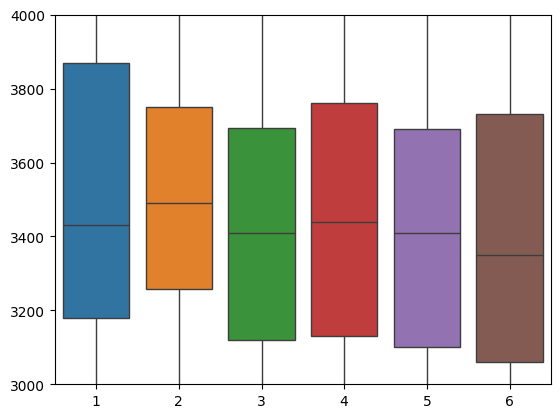

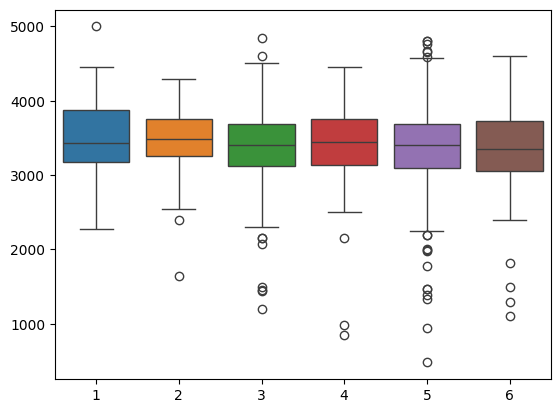

F_onewayResult(statistic=1.279199321061533, pvalue=0.27029606407619317) [88, 92, 260, 97, 688, 93]


In [6]:
ax = sns.boxplot(data=t_weight)
ax.set_ylim([3000, 4000])
plt.show()

ax = sns.boxplot(data=t_weight)
#ax.set_ylim([3000, 4000])
plt.show()
avona = f_oneway(*t_weight.values())
print(avona, [len(tmp) for tmp in t_weight.values()])

In [7]:
table_pV = pd.DataFrame(columns=t_weight.keys(),
 index=t_weight)
table_stat = table_pV.copy()

for i in t_weight:
    for j in t_weight:
        st, pV = ttest_ind(t_weight[i],t_weight[j], equal_var = False)#t-критерий Уэлча
        table_stat.loc[i,j] = round(st, 3)
        table_pV.loc[i,j] = round(pV, 3)
print('statistic\n', table_stat)
print('pValue\n', table_pV)

now = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
name_st = './results/st_result_'+ now + '.xlsx'
name_pv = './results/pv_result_'+ now + '.xlsx'
table_stat.to_excel(name_st, sheet_name='statistic')
table_pV.to_excel(name_pv, sheet_name='pValue')

statistic
        1      2      3      4      5      6
1    0.0   0.05  1.615  1.095  1.698  1.825
2  -0.05    0.0   1.65  1.087  1.756  1.838
3 -1.615  -1.65    0.0 -0.192 -0.129  0.722
4 -1.095 -1.087  0.192    0.0  0.129  0.746
5 -1.698 -1.756  0.129 -0.129    0.0  0.847
6 -1.825 -1.838 -0.722 -0.746 -0.847    0.0
pValue
        1      2      3      4      5      6
1    1.0   0.96  0.108  0.275  0.092   0.07
2   0.96    1.0  0.101  0.278  0.082  0.068
3  0.108  0.101    1.0  0.848  0.897  0.471
4  0.275  0.278  0.848    1.0  0.898  0.457
5  0.092  0.082  0.897  0.898    1.0  0.399
6   0.07  0.068  0.471  0.457  0.399    1.0


In [8]:
t_weight_mean = t_weight.copy()
for i in t_weight_mean:
    t_weight_mean[i] = np.mean(t_weight_mean[i])

In [9]:
city_coord = [56.15, 43.6]
m = folium.Map(location = city_coord)
geo = templates

#state_data = data
folium.Choropleth(
    geo_data=geo,
    name="choropleth",
    data=t_weight_mean,
    #columns=[state_data.index, 'weight'],
    key_on='feature.properties.id',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Height",
).add_to(m)

m